In [12]:
# import dependencies 
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss, confusion_matrix 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib.pyplot as plt
import os
%matplotlib inline 

# Load Data

In [23]:
# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/data_for_model"

In [27]:
# function to load data 
def load_data(filename, root_path=DATAFOLDER):
    csv_path = os.path.join(root_path, filename)
    df = pd.read_csv(csv_path)
    return df 

In [28]:
# load data 
df = load_data(filename="data_for_model_2018-05-03.csv", root_path=DATAFOLDER)
df.set_index('idnAppeal', inplace=True) 
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247280 entries, 4657002 to 5021568
Data columns (total 15 columns):
nat_string             247121 non-null object
strCustody             206419 non-null object
strProbono             486 non-null object
case_type_string       247278 non-null object
ij_code                247280 non-null object
lawyer                 247280 non-null int64
defensive              241611 non-null float64
affirmative            241611 non-null float64
oral                   246827 non-null float64
written                246827 non-null float64
comp_year              247280 non-null int64
osc_year               247280 non-null float64
input_year             247269 non-null float64
datAppealFiled_year    247280 non-null float64
granted                247280 non-null int64
dtypes: float64(7), int64(3), object(5)
memory usage: 30.2+ MB


# Data Pipelines

In [16]:
# impute missing data

def impute_columns_udf(col, imputation_type): 
    """ 
    UDF to specify imputation method for a given variable. 
    col is the pd.Series for which you want to impute, imputation_type should be chosen from 
    ['mode', 'mean', 'zero', 'none'] 
    """ 
    if imputation_type == 'mode':
        val = col.mode()[0]
        return col.fillna(val)
    
    elif imputation_type == 'mean': 
        val = col.mean() 
        return col.fillna(val)
    
    elif imputation_type == 'zero': 
        return col.fillna(0)
    
    elif imputation_type == 'none':
        return col.fillna('None')
    
    else: 
        raise ValueError('imputation_type argument not valid')

class ImputeMissingData(BaseEstimator, TransformerMixin):
    """ Pipeline step that impute missing values, given impute methods specified. 
        Note that numerical features with NaN's and no impute methods will raise an error, 
        categorical features on the other hand will be filled with 'None' by default unless specified otherwise.
    """
    def __init__(self, impute_methods, num_features, cat_features): 
        self.impute_methods = impute_methods
        self.num_features = num_features
        self.cat_features = cat_features
    
    def fit(self, X, y=None): 
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 

        # check which features have missing values but imputation methods not specified 
        features_nulls = output_data.isnull().sum() 
        features_nulls = features_nulls[features_nulls > 0].index.tolist() 
        features_need_impute = [f for f in features_nulls if f not in self.impute_methods.keys()]
        num_features_need_impute = [f for f in features_need_impute if f in self.num_features]
        cat_features_need_impute = [f for f in features_need_impute if f in self.cat_features]
        
        # raise exception for numerical features with missing values and no imputation method specified 
        if num_features_need_impute: 
            raise Exception("""These numerical features have missing values: {}. 
            Please specify their impute methods.""".format(num_features_need_impute)) 
        
        # set imputation method as 'none' for cat features with missing values with no imputation method specified 
        if cat_features_need_impute: 
            for cat_f in cat_features_need_impute: 
                self.impute_methods[cat_f] = 'none'
            print("""{} have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.""".format(cat_features_need_impute)) 
                
        # apply imputations 
        for col, imp_method in self.impute_methods.items(): 
            output_data[col] = impute_columns_udf(output_data[col], imp_method)
            
        return output_data 

In [17]:
# convert data types
class ConvertDataTypes(BaseEstimator, TransformerMixin): 
    """ Coerce data types to specifications defined by CAT_FEATURES and NUM_FEATURES """
    def __init__(self, num_features, cat_features): 
        self.num_features = num_features 
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 
        output_data[self.num_features] = output_data[self.num_features].astype(float)
        output_data[self.cat_features] = output_data[self.cat_features].astype(str)
        return output_data 

In [18]:
# dummify data 

class Dummify(BaseEstimator, TransformerMixin): 
    """ Pipeline step that dummifies all categorical variables """
    def __init__(self, cat_feature_values): 
        self.cat_feature_values = cat_feature_values
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, input_data):
        output_data = input_data.copy()
        # specify values categorical features can take on, to ensure train/test DF have same cols 
        cat_features = self.cat_feature_values.keys()
        for col in cat_features: 
            output_data[col] = pd.Categorical(output_data[col], categories=self.cat_feature_values[col])        
        output_data = pd.get_dummies(output_data, columns=cat_features, prefix_sep=':::')
        return output_data

# Model Methods

In [19]:
# method to subset data for training model 
def get_model_data(df, label, cat_features, num_features, impute_methods): 
    """ Subsets variables used for model, runs it through pipeline to output data for model """
    
    # subsets features we are interested in 
    cat_feature_values = dict([(f, [str(x) for x in df[f].dropna().unique().tolist()]) for f in cat_features]) # do EDA and limit to smaller list
    data = df[cat_features + num_features + [label]].copy() 
    
    # train test split 
    X, y = data.drop(label, axis=1).copy(), data[label].copy() 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # make pipeline 
    data_pipeline = Pipeline([
        ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
        ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
        ('dummify', Dummify(cat_feature_values))
    ])
    
    # run pipeline 
    X_train = data_pipeline.fit_transform(x_train)
    X_test = data_pipeline.transform(x_test)
    print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
    return X_train, X_test, y_train, y_test 

In [20]:
# method to output evaluation metrics and plot ROC curve 

def evaluate_model(truth, pred, plot_auc): 
    """ Takes in arrays of truth and pred y values and return accuracy, logloss, roc_auc, and plot ROC """ 
    accuracy = accuracy_score(truth, (pred>0.5).astype(int))
    logloss = log_loss(truth, pred)
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    metrics = {'Accuracy': accuracy, 'ROC AUC': roc_auc, 'Log Loss': logloss}
    if plot_auc: 
        plt.plot(fpr, tpr, label= 'AUC = {0:.3f}'.format(roc_auc)) 
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC')
        plt.legend(loc="lower right")
    else: pass 
    return metrics 

In [21]:
# method to train a model, output results, and plot AUC 

def train_model(model, plot_auc=True, print_metrics=True, sample_weight=None):
    if sample_weight is not None: 
        model.fit(X_train, y_train.values.ravel(), sample_weight)
    else: 
        model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict_proba(X_test)[:,1]
    metrics = evaluate_model(y_test.values.ravel(), y_pred, plot_auc)
    if print_metrics: 
        print(metrics)
    return model, metrics 

# Test Different Variables 

#### One Variable  

Training Data: (197824, 217) | Test Data: (49456, 217)
{'Accuracy': 0.6824045616305403, 'ROC AUC': 0.6617185370249173, 'Log Loss': 0.5922826408449247}


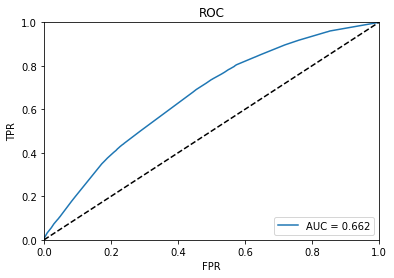

In [11]:
# nationality only 
CAT_FEATURES = ['nat_string']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (197824, 421) | Test Data: (49456, 421)
{'Log Loss': 0.60649674527728692, 'ROC AUC': 0.62693024652750928, 'Accuracy': 0.68040278227110962}


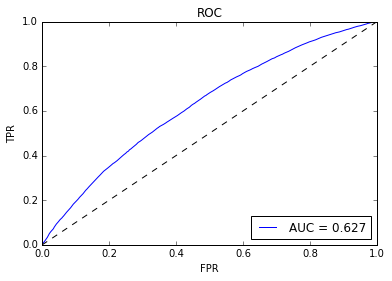

In [71]:
# judge only 
CAT_FEATURES = ['ij_code']
NUM_FEATURES = []
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (197824, 1) | Test Data: (49456, 1)
{'Log Loss': 0.61511354224720671, 'ROC AUC': 0.59775929000533323, 'Accuracy': 0.68028146230993203}


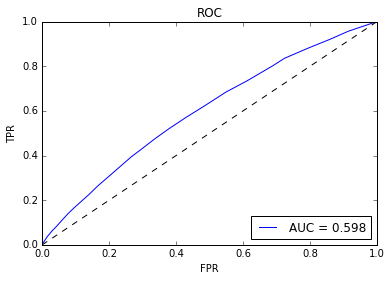

In [72]:
# appeal year only
CAT_FEATURES = []
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

#### Two Variables 

Training Data: (197824, 638) | Test Data: (49456, 638)
{'Log Loss': 0.86349306945915261, 'ROC AUC': 0.70216271347410475, 'Accuracy': 0.70666855386606275}


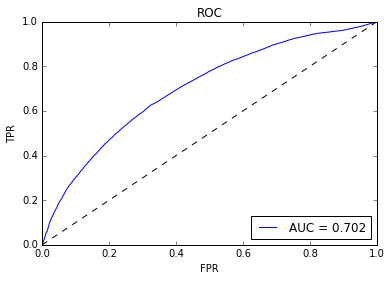

In [73]:
# nationality + judge 
CAT_FEATURES = ['nat_string', 'ij_code']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (197824, 218) | Test Data: (49456, 218)
{'Log Loss': 0.60971303546771549, 'ROC AUC': 0.73674867617806061, 'Accuracy': 0.72860724684568101}


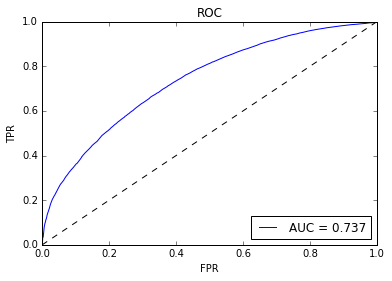

In [74]:
# nationality + appeal year 
CAT_FEATURES = ['nat_string']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (197824, 422) | Test Data: (49456, 422)
{'Log Loss': 0.64512353592924276, 'ROC AUC': 0.6838830311336157, 'Accuracy': 0.69793351666127468}


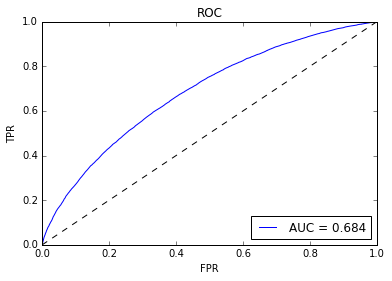

In [75]:
# judge + appeal year 
CAT_FEATURES = ['ij_code']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

#### Multiple Variables  

Training Data: (197824, 639) | Test Data: (49456, 639)
{'Log Loss': 1.4053877709660074, 'ROC AUC': 0.76103521662443652, 'Accuracy': 0.7410627628599159}


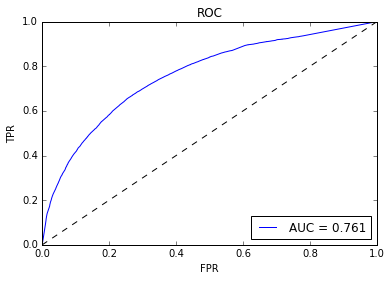

In [76]:
# nationality + judge + appeal year 
CAT_FEATURES = ['nat_string', 'ij_code']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (197824, 644) | Test Data: (49456, 644)
{'Log Loss': 1.3981630112027972, 'ROC AUC': 0.76931087153550215, 'Accuracy': 0.74757360077644774}


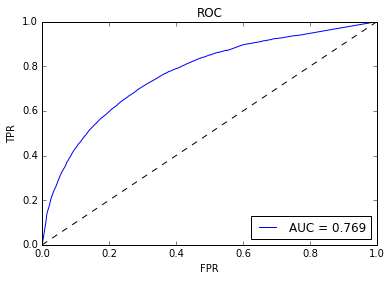

In [77]:
# nationality + judge + appeal year + case type 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none', 'case_type_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (197824, 648) | Test Data: (49456, 648)
{'Log Loss': 1.4679471884690978, 'ROC AUC': 0.77320639598845686, 'Accuracy': 0.74975736007764482}


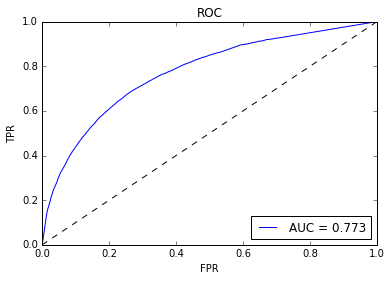

In [78]:
# nationality + judge + appeal year + case type + custody + probono
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none'}  
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (197824, 653) | Test Data: (49456, 653)
{'Log Loss': 1.417338238887746, 'ROC AUC': 0.78112544956991947, 'Accuracy': 0.75554027822711101}


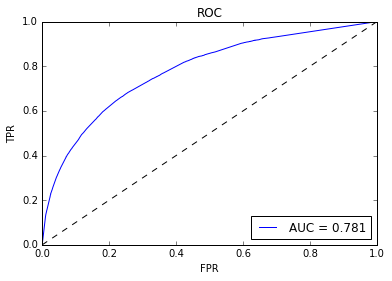

In [79]:
# nationality + judge + appeal year + case type + custody + probono + lawyer + defensive/affirmative, oral/written
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (197824, 656) | Test Data: (49456, 656)
{'Log Loss': 1.2995033517079897, 'ROC AUC': 0.804096615590431, 'Accuracy': 0.77325299255904234}


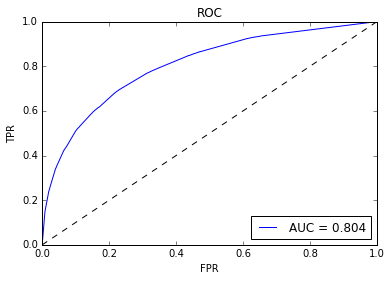

In [80]:
# nationality + judge + appeal year + case type + custody + probono + lawyer + defensive/affirmative, oral/written 
# + comp/osc/input years 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (197824, 656) | Test Data: (49456, 656)
{'Accuracy': 0.7824935296020705, 'ROC AUC': 0.8237158494967738, 'Log Loss': 0.6360556905221462}


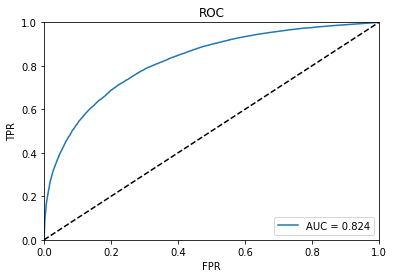

In [22]:
# same as above but more trees 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=100))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_model, rf_metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (197824, 235) | Test Data: (49456, 235)
{'Accuracy': 0.7593214170171465, 'ROC AUC': 0.7872754513081758, 'Log Loss': 0.7406981916974775}


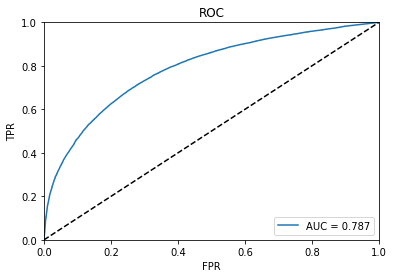

In [26]:
# without judge 
CAT_FEATURES = ['nat_string', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=100))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_model_no_judge, rf_metrics_no_judge = train_model(model=MODEL, plot_auc=True, print_metrics=True)

# Fit Different Algorithms

#### Logistic Regression

Training Data: (197824, 821) | Test Data: (49456, 821)
{'Log Loss': 0.54226301879318939, 'ROC AUC': 0.74429452967526188, 'Accuracy': 0.72674700744095766}


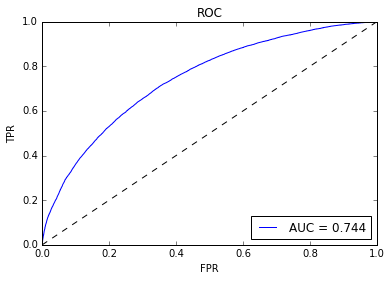

In [82]:
# for lr we dummify "numerical variables" so we don't assume any linear or monotonic relationship 
# between the numerical variable and log odds 

from sklearn.linear_model import LogisticRegression

CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono', 
                'datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
NUM_FEATURES = []  
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (LogisticRegression(penalty='l2', C=1))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
lr_model, lr_metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

#### Gradient Boosting

Training Data: (197824, 656) | Test Data: (49456, 656)
{'Log Loss': 0.538824054292661, 'ROC AUC': 0.75455556121848355, 'Accuracy': 0.73327806535101914}


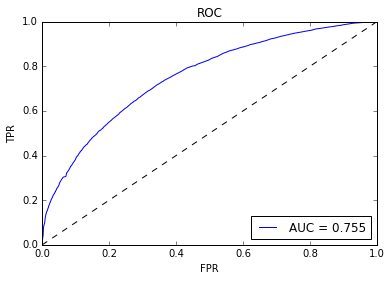

In [83]:
from sklearn.ensemble import GradientBoostingClassifier

CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (GradientBoostingClassifier(loss='deviance', learning_rate=.1, n_estimators=100))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
gb_model, gb_metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

#### XGBoost 

Training Data: (197824, 656) | Test Data: (49456, 656)
{'Log Loss': 0.53772080492557295, 'ROC AUC': 0.75561697207287648, 'Accuracy': 0.7321861857004206}


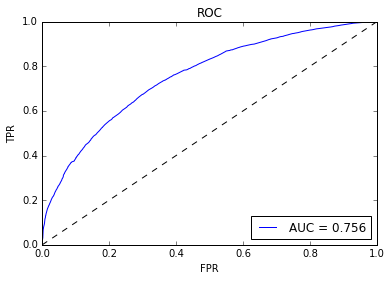

In [84]:
from xgboost import XGBClassifier

CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
xgb_model, xgb_metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

#### Algorithm Comparison (out-of-the-box)

In [85]:
algo_comparison = {'Random Forest': rf_metrics, 
                   'Logistic Regression': lr_metrics, 
                   'Gradient Boosting': gb_metrics, 
                   'XGBoost': xgb_metrics}

pd.DataFrame.from_dict(algo_comparison, orient='index').sort_values(by='ROC AUC', ascending=False)

Log Loss   ROC AUC  Accuracy
Random Forest        0.638087  0.823996  0.781240
XGBoost              0.537721  0.755617  0.732186
Gradient Boosting    0.538824  0.754556  0.733278
Logistic Regression  0.542263  0.744295  0.726747

Since Random Forest outperforms other algorithms significantly in accuracy and ROC AUC out-of-the-box, we will move forward with Random Forest and tune it to get our best model.  

# Tune Random Forest 

In [165]:
from sklearn.model_selection import GridSearchCV

# define search scope 
max_features = ['sqrt', 'log2']
max_depth = list(np.arange(10, 150, 10))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# construct param grid 
param_grid = {'max_features': max_features, 'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# run randomized search cv 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
X_train, _, y_train, _ = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_clf = RandomForestClassifier(n_estimators=20)
rf_gridsearch = GridSearchCV(rf_clf, param_grid, scoring=['roc_auc', 'accuracy', 'neg_log_loss'], refit='roc_auc')
rf_gridsearch.fit(X_train, y_train)

Training Data: (197824, 656) | Test Data: (49456, 656)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=['roc_auc', 'accuracy', 'neg_log_loss'], verbose=0)

In [168]:
def evaluate_search_cv(cv_object): 
    """ Print results for randomized search cv """
    rename_cols = {'param_max_depth': 'max_depth', 
                   'param_max_features': 'max_features', 
                   'param_min_samples_leaf': 'min_samples_leaf', 
                   'param_min_samples_split': 'min_samples_split', 
                   'mean_test_roc_auc': 'roc_auc', 
                   'mean_test_accuracy': 'accuracy', 
                   'mean_train_neg_log_loss': 'neg_log_loss'}
    results = pd.DataFrame(cv_object.cv_results_)
    results.rename(columns=rename_cols, inplace=True)
    results = results[['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 
                       'roc_auc', 'accuracy', 'neg_log_loss']]
    return results.sort_values(by='roc_auc', ascending=False)

In [169]:
evaluate_search_cv(rf_gridsearch)

max_depth max_features min_samples_leaf min_samples_split   roc_auc  \
164       100         sqrt                1                10  0.811757   
254      None         sqrt                1                10  0.811488   
200       120         sqrt                1                10  0.811389   
182       110         sqrt                1                10  0.811372   
218       130         sqrt                1                10  0.811127   
146        90         sqrt                1                10  0.811055   
128        80         sqrt                1                10  0.810963   
127        80         sqrt                1                 5  0.810818   
163       100         sqrt                1                 5  0.810774   
145        90         sqrt                1                 5  0.810604   
110        70         sqrt                1                10  0.810435   
236       140         sqrt                1                10  0.810339   
91         60         sqrt                1                 5  0.810171   
181       110         sqrt                1                 5  0.810024   
109        70         sqrt                1                 5  0.809912   
199       120         sqrt                1                 5  0.809736   
217       130         sqrt                1                 5  0.809714   
253      None         sqrt                1                 5  0.809631   
235       140         sqrt                1                 5  0.809480   
108        70         sqrt                1                 2  0.808654   
90         60         sqrt                1                 2  0.808204   
126        80         sqrt                1                 2  0.808174   
92         60         sqrt                1                10  0.808085   
263      None         log2                1                10  0.807160   
209       120         log2                1                10  0.807102   
227       130         log2                1                10  0.806581   
73         50         sqrt                1                 5  0.806578   
144        90         sqrt                1                 2  0.806481   
162       100         sqrt                1                 2  0.806456   
191       110         log2                1                10  0.806417   
..        ...          ...              ...               ...       ...   
52         30         log2                4                 5  0.725318   
53         30         log2                4                10  0.724582   
51         30         log2                4                 2  0.723559   
27         20         log2                1                 2  0.722449   
29         20         log2                1                10  0.719925   
31         20         log2                2                 5  0.717016   
2          10         sqrt                1                10  0.716089   
1          10         sqrt                1                 5  0.714919   
28         20         log2                1                 5  0.714637   
5          10         sqrt                2                10  0.713478   
0          10         sqrt                1                 2  0.712803   
32         20         log2                2                10  0.712157   
4          10         sqrt                2                 5  0.711434   
7          10         sqrt                4                 5  0.710998   
6          10         sqrt                4                 2  0.710949   
35         20         log2                4                10  0.710574   
3          10         sqrt                2                 2  0.709169   
33         20         log2                4                 2  0.705982   
30         20         log2                2                 2  0.705763   
34         20         log2                4                 5  0.705302   
8          10         sqrt                4                10  0.703293   
13         10         log2   

In [178]:
print rf_gridsearch.best_params_

{'max_features': 'sqrt', 'min_samples_split': 10, 'max_depth': 100, 'min_samples_leaf': 1}


Training Data: (197824, 656) | Test Data: (49456, 656)
{'Accuracy': 0.783282109349725, 'ROC AUC': 0.8267267552086093, 'Log Loss': 0.4666812293189677}


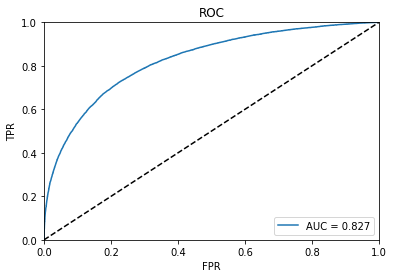

In [11]:
# retrain with best params on 100 trees 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=10, max_features='sqrt', 
                                max_depth=100, min_samples_leaf=1))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_best_model, rf_best_metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

In [180]:
algo_comparison_tuned = {'Random Forest (Tuned)': rf_best_metrics,
                         'Random Forest': rf_metrics} 

pd.DataFrame.from_dict(algo_comparison_tuned, orient='index').sort_values(by='ROC AUC', ascending=False)

Log Loss   ROC AUC  Accuracy
Random Forest (Tuned)   0.46813  0.826877  0.783949
Random Forest           0.63749  0.823695  0.781503

# Probability Calibration

Probability calibration can sometimes be an issue for random forest. But it appears that our classifier is already well-calibrated, so we deem it unnecessary to proceed with calibration methods like Platt Scaling. 

In [181]:
from sklearn.calibration import calibration_curve 
y_pred_outofbox = rf_model.predict_proba(X_test)[:,1]
y_pred_best = rf_best_model.predict_proba(X_test)[:,1]
calibration_outofbox = calibration_curve(y_test, y_pred_outofbox, n_bins=10)
calibration_best = calibration_curve(y_test, y_pred_best, n_bins=10)

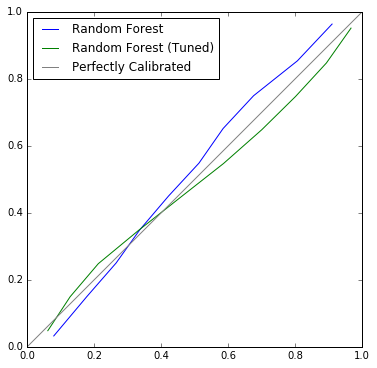

In [182]:
plt.figure(figsize=(6, 6))
plt.plot(calibration_outofbox[0], calibration_outofbox[1], label='Random Forest')
plt.plot(calibration_best[0], calibration_best[1], label='Random Forest (Tuned)')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='Perfectly Calibrated', color='grey')
plt.legend(loc='best');

# Feature Importance 

In [183]:
feature_importances = pd.Series(data=rf_best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.head(20)

datAppealFiled_year               0.132974
comp_year                         0.069698
input_year                        0.058297
osc_year                          0.057454
nat_string:::EL SALVADOR          0.032756
nat_string:::HAITI                0.028217
nat_string:::GUATEMALA            0.014084
lawyer                            0.013141
strCustody:::D                    0.011802
case_type_string:::DEPORTATION    0.011761
strCustody:::N                    0.011240
nat_string:::NICARAGUA            0.009821
nat_string:::CHINA                0.009065
nat_string:::IRAQ                 0.007984
affirmative                       0.007319
strCustody:::R                    0.005990
defensive                         0.005972
case_type_string:::REMOVAL        0.005804
oral                              0.005788
nat_string:::INDIA                0.004868
dtype: float64

In [184]:
#TODO: Group dummy variables that are not well-represented in dataset 
feature_importances.tail(20)

ij_code:::GRG                            1.166305e-06
nat_string:::SAMOA                       9.002720e-07
ij_code:::TAW                            8.783080e-07
nat_string:::MALDIVES                    8.020317e-07
nat_string:::SWAZILAND                   7.856280e-07
nat_string:::TURKS AND CAICOS ISLANDS    6.570152e-07
ij_code:::CAH                            5.456547e-07
ij_code:::BSC                            5.139482e-07
ij_code:::TRE                            3.719896e-07
nat_string:::KIRIBATI                    2.712985e-07
nat_string:::FAEROE ISLAND               2.594594e-07
nat_string:::ICELAND                     2.447923e-07
nat_string:::MONACO                      1.938717e-07
nat_string:::BRITISH VIRGIN ISLANDS      7.735639e-08
nat_string:::NAURU                       7.455803e-08
nat_string:::ARUBA                       6.631391e-08
nat_string:::MARTINIQUE                  6.589674e-08
nat_string:::BRITISH WEST INDIES         0.000000e+00
ij_code:::EHM               

In [39]:
# Collapse feature importances for dummy variables onto their respective parent 
def collapse_feature_importances(feature_importances): 
    """ Takes a pd.Series representing feature importances of all input variables including dummies 
        Returns a pd.Series representing feature importances where those dummies are collapsed into parent variable 
        Assumes ':::' was used as separator in one-hot-encoding 
    """
    cfi = pd.DataFrame(feature_importances).reset_index().rename(
        columns={'index': 'feature', 0: 'importance'})
    cfi['parent_feature'] = cfi['feature'].apply(lambda x: x.split(':::')[0])
    return cfi.groupby('parent_feature')['importance'].sum().sort_values(ascending=False) 

In [40]:
collapsed_feature_importances = collapse_feature_importances(feature_importances)
collapsed_feature_importances

parent_feature
nat_string               0.263892
datAppealFiled_year      0.139951
ij_code                  0.122998
comp_year                0.078548
osc_year                 0.069109
input_year               0.066857
strCustody               0.032452
case_type_string         0.024506
Year_College_SLR         0.023445
Year_Law_school_SLR      0.022929
Year_Appointed_SLR       0.022745
Government_Years_SLR     0.016568
Privateprac_Years_SLR    0.016319
INS_Years_SLR            0.016005
lawyer                   0.013878
Govt_nonINS_SLR          0.013406
Male_judge               0.008933
affirmative              0.008488
defensive                0.007467
NGO_Years_SLR            0.007307
oral                     0.006813
written                  0.005936
Military_Years_SLR       0.005911
Academia_Years_SLR       0.002769
judge_missing_bio        0.001774
strProbono               0.000995
Name: importance, dtype: float64

# Partial Dependence Plots

In [51]:
from pdpbox import pdp

def pdp_plot(model, X_train, feature, feature_is_cat=False, isolate_samples=1000, plot_samples=200): 
    """
    Uses pdpbox package to plot partial dependence plot. Accepts trained classifier (model), X_train, 
    and feature name as inputs. Feature chosen may be categorical, in which case the function will retrieve 
    all the corresponding dummy variables. 
    """ 
    
    # if feature is categorical, generate list of dummy variable names, else use feature name 
    if feature_is_cat: 
        plot_feature = [x for x in X_train.columns if feature + ':::' in x]
    else: 
        plot_feature = feature 

    # use pdpbox methods 
    pdp_isolate = pdp.pdp_isolate(model, X_train.sample(n=isolate_samples), plot_feature)
    pdp.pdp_plot(pdp_isolate, feature, plot_org_pts=True, plot_lines=True, center=False, frac_to_plot=plot_samples)

AttributeError: 'AxesSubplot' object has no attribute 'set_facecolor'

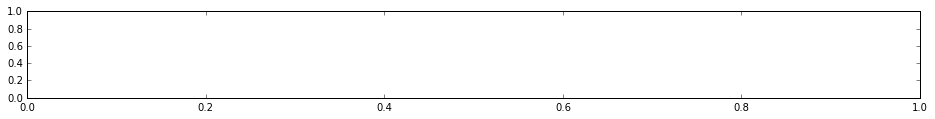

In [189]:
pdp_plot(rf_best_model, X_train, 'datAppealFiled_year', feature_is_cat=False)

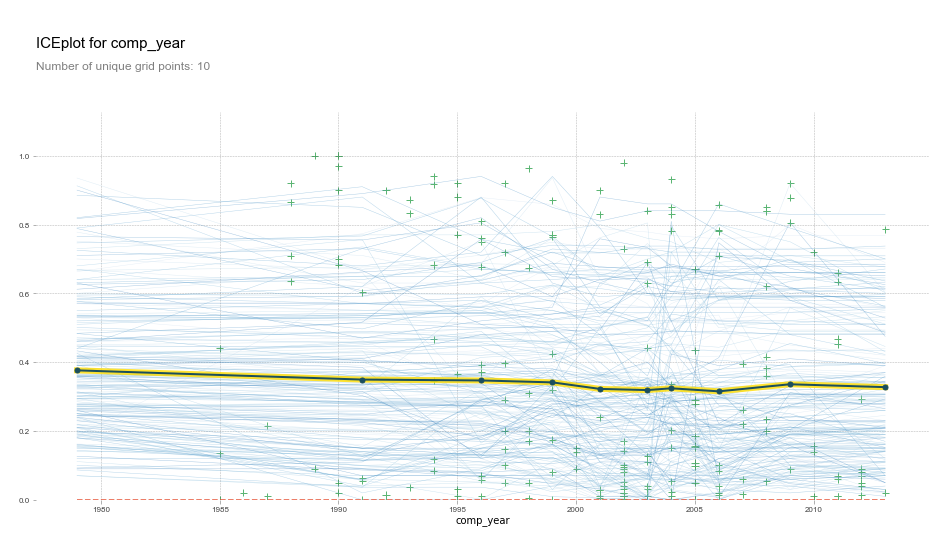

In [29]:
pdp_plot(rf_model, X_train, 'comp_year', feature_is_cat=False)

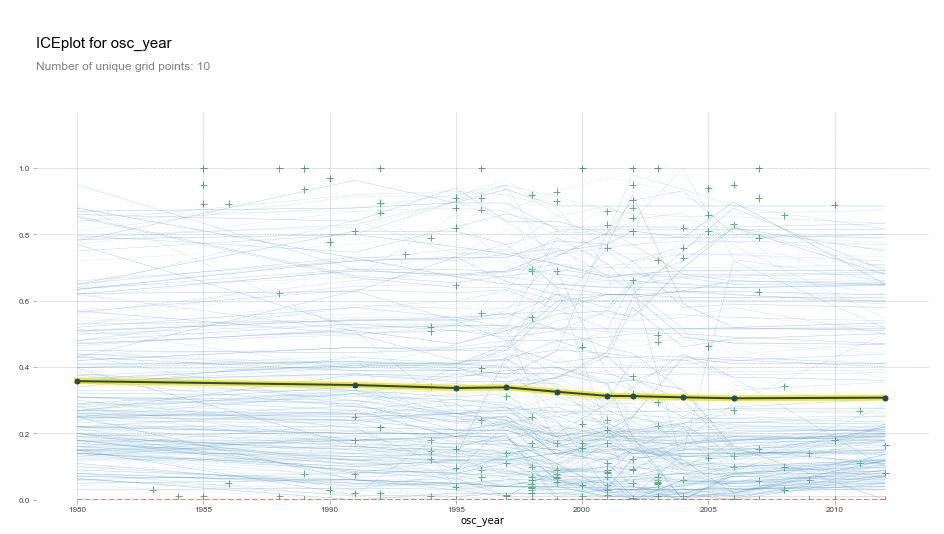

In [30]:
pdp_plot(rf_model, X_train, 'osc_year', feature_is_cat=False)

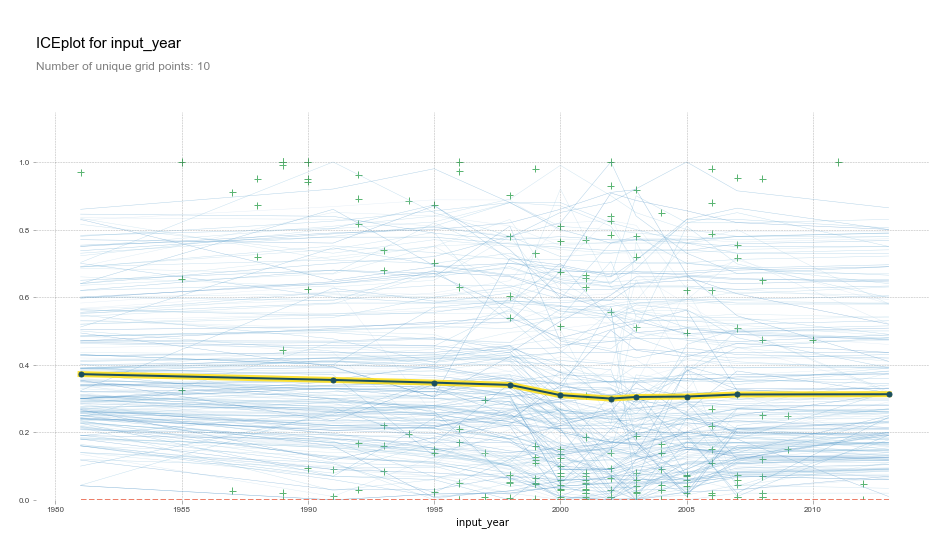

In [31]:
pdp_plot(rf_model, X_train, 'input_year', feature_is_cat=False)

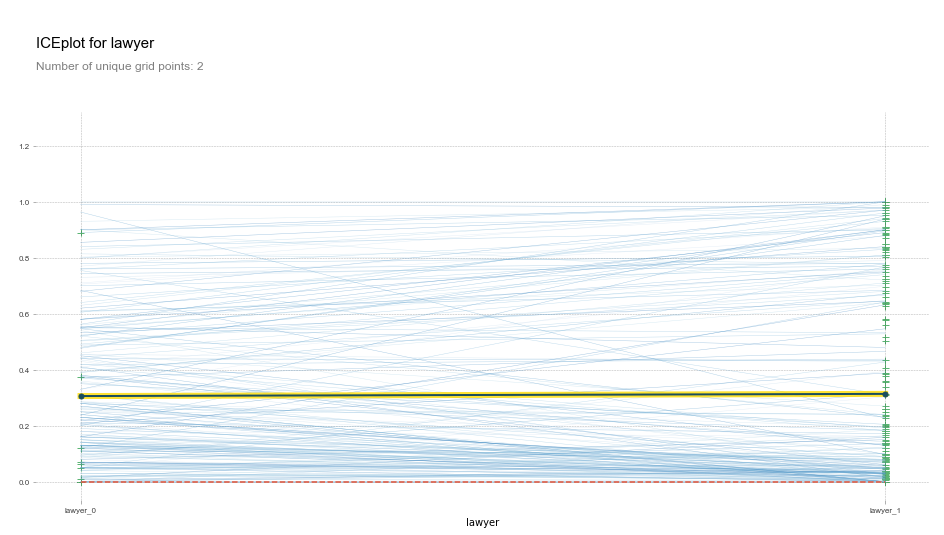

In [32]:
pdp_plot(rf_model, X_train, 'lawyer', feature_is_cat=False)

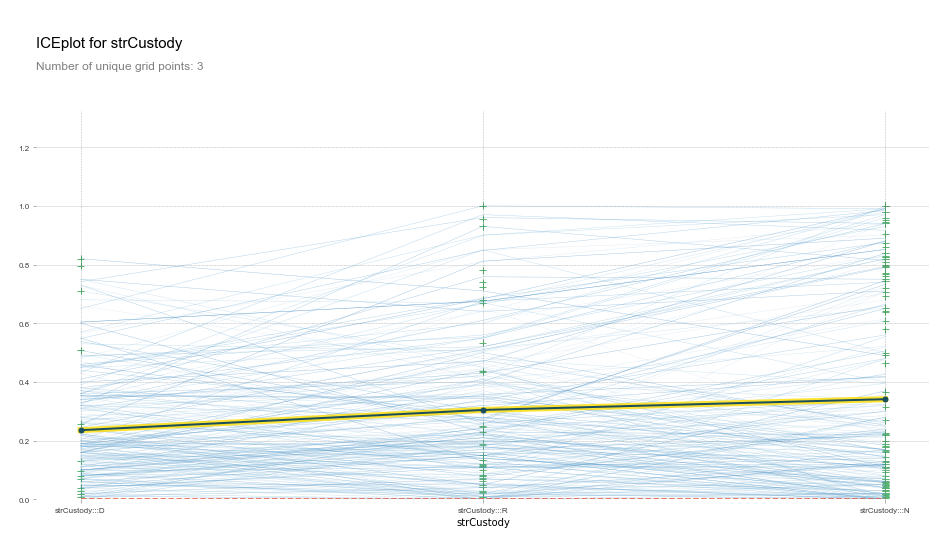

In [33]:
pdp_plot(rf_model, X_train, 'strCustody', feature_is_cat=True)

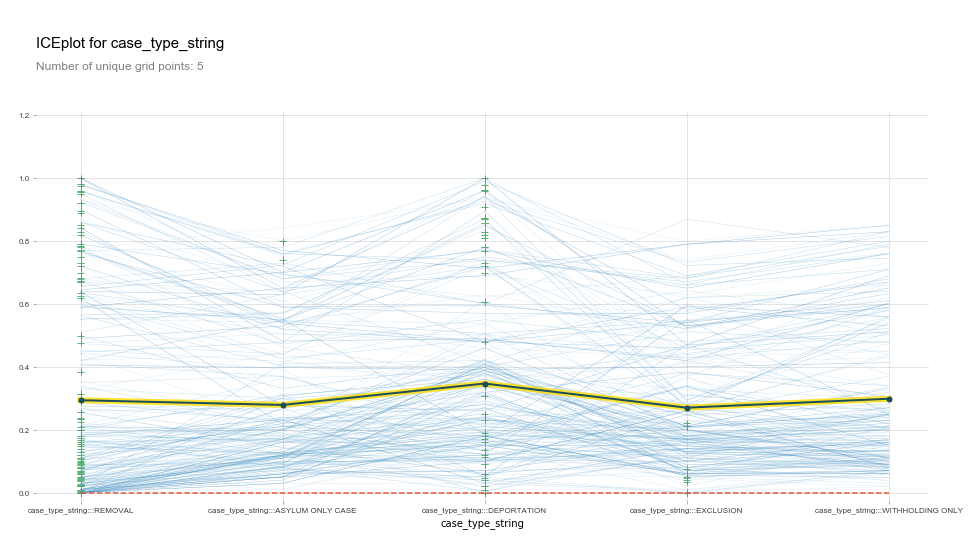

In [53]:
pdp_plot(rf_model, X_train, 'case_type_string', feature_is_cat=True)

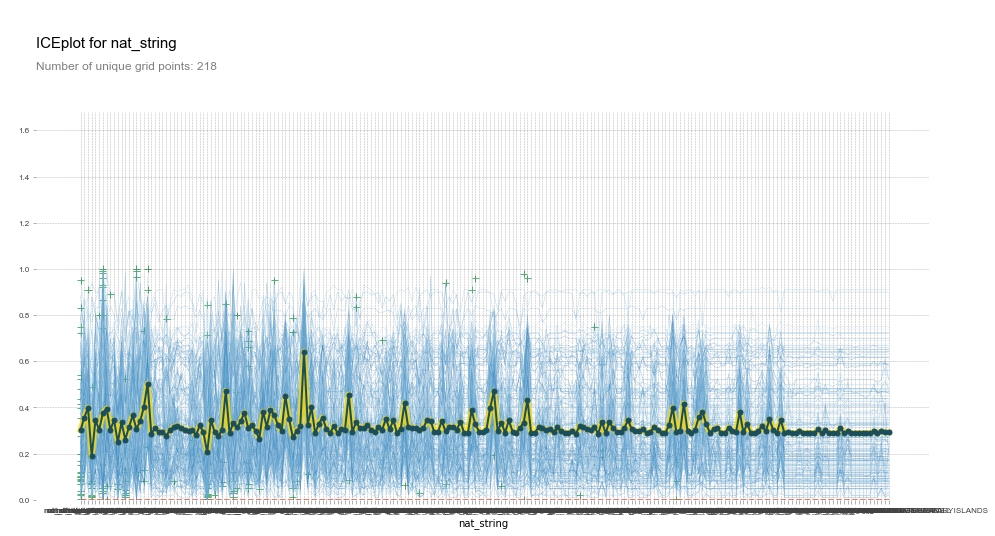

In [50]:
# TODO: reduce dimensionality of nat_string 
pdp_plot(rf_model, X_train, 'nat_string', feature_is_cat=True)

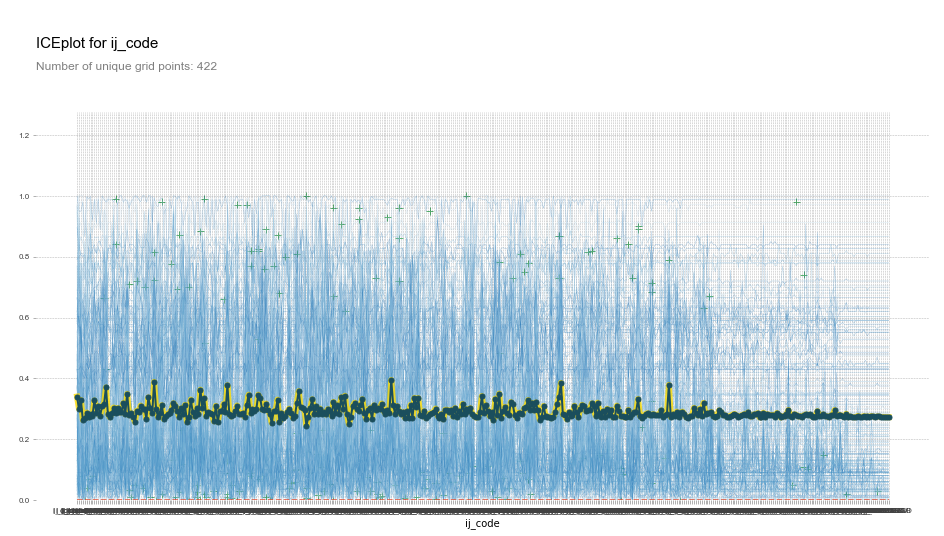

In [52]:
# TODO: reduce dimensionality of ij_code / use clusters
pdp_plot(rf_model, X_train, 'ij_code', feature_is_cat=True)

# Use Judge Clusters

In [13]:
judge_clusters = pd.read_csv(os.path.join(DATAFOLDER, "judge_clustering_labels.csv"))
cluster_models = [c for c in judge_clusters.columns if c != 'judge']
print(cluster_models)

['kmeans-4', 'GMM-4', 'hierarchical-4', 'kmeans-5', 'GMM-5', 'hierarchical-5', 'kmeans-6', 'GMM-6', 'hierarchical-6', 'kmeans-8', 'GMM-8', 'hierarchical-8', 'kmeans-10', 'GMM-10', 'hierarchical-10', 'kmeans-15', 'GMM-15', 'hierarchical-15', 'kmeans-20', 'GMM-20', 'hierarchical-20']


In [14]:
df_cluster = df.merge(judge_clusters, how='left', left_on='ij_code', right_on='judge')
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247280 entries, 0 to 247279
Data columns (total 37 columns):
nat_string             247121 non-null object
strCustody             206419 non-null object
strProbono             486 non-null object
case_type_string       247278 non-null object
ij_code                247280 non-null object
lawyer                 247280 non-null int64
defensive              241611 non-null float64
affirmative            241611 non-null float64
oral                   246827 non-null float64
written                246827 non-null float64
comp_year              247280 non-null int64
osc_year               247280 non-null float64
input_year             247269 non-null float64
datAppealFiled_year    247280 non-null float64
granted                247280 non-null int64
judge                  247280 non-null object
kmeans-4               247280 non-null int64
GMM-4                  247280 non-null int64
hierarchical-4         247280 non-null int64
kmeans-5         

In [120]:
# Run RF with 10 trees using only Judge Cluster Variable 
cluster_only = {} 
for cm in cluster_models: 
    CAT_FEATURES = [cm]
    NUM_FEATURES = []
    IMPUTE_METHODS = {}
    MODEL = (RandomForestClassifier(n_estimators=10))

    X_train, X_test, y_train, y_test = get_model_data(df_cluster, label='granted', cat_features = CAT_FEATURES, 
                                                      num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
    _, cluster_only[cm] = train_model(model=MODEL, plot_auc=False, print_metrics=False)    

Training Data: (197824, 4) | Test Data: (49456, 4)
Training Data: (197824, 4) | Test Data: (49456, 4)
Training Data: (197824, 4) | Test Data: (49456, 4)
Training Data: (197824, 5) | Test Data: (49456, 5)
Training Data: (197824, 5) | Test Data: (49456, 5)
Training Data: (197824, 5) | Test Data: (49456, 5)
Training Data: (197824, 6) | Test Data: (49456, 6)
Training Data: (197824, 6) | Test Data: (49456, 6)
Training Data: (197824, 6) | Test Data: (49456, 6)
Training Data: (197824, 8) | Test Data: (49456, 8)
Training Data: (197824, 8) | Test Data: (49456, 8)
Training Data: (197824, 8) | Test Data: (49456, 8)
Training Data: (197824, 10) | Test Data: (49456, 10)
Training Data: (197824, 10) | Test Data: (49456, 10)
Training Data: (197824, 10) | Test Data: (49456, 10)
Training Data: (197824, 15) | Test Data: (49456, 15)
Training Data: (197824, 15) | Test Data: (49456, 15)
Training Data: (197824, 15) | Test Data: (49456, 15)
Training Data: (197824, 20) | Test Data: (49456, 20)
Training Data: (1

In [122]:
pd.DataFrame.from_dict(cluster_only, orient='index').sort_values(by='ROC AUC', ascending=False)

Log Loss   ROC AUC  Accuracy
hierarchical-20  0.622870  0.556745  0.678785
GMM-20           0.623444  0.554151  0.678785
GMM-15           0.623485  0.552741  0.678785
hierarchical-15  0.624549  0.547801  0.678785
GMM-10           0.624470  0.544394  0.678785
GMM-8            0.625075  0.544296  0.678785
hierarchical-10  0.624902  0.541907  0.678785
kmeans-20        0.625476  0.540847  0.678785
kmeans-15        0.625887  0.535310  0.678785
kmeans-10        0.626538  0.529481  0.678785
kmeans-8         0.626614  0.528580  0.678785
kmeans-6         0.626808  0.525871  0.678785
kmeans-5         0.626883  0.524859  0.678785
hierarchical-8   0.626887  0.523935  0.678785
hierarchical-5   0.626979  0.523070  0.678785
GMM-6            0.627153  0.518824  0.678785
hierarchical-6   0.627305  0.518626  0.678785
GMM-5            0.627653  0.511468  0.678785
GMM-4            0.627697  0.508261  0.678785
kmeans-4         0.627695  0.508261  0.678785
hierarchical-4   0.627786  0.504805  0.678785

In [123]:
# Run RF with 10 trees replacing ij code with judge cluster 
cluster_replacement = {} 
for cm in cluster_models: 
    CAT_FEATURES = [cm, 'nat_string', 'case_type_string', 'strCustody', 'strProbono']
    NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                    'comp_year', 'osc_year', 'input_year']
    IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                      'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
    MODEL = (RandomForestClassifier(n_estimators=10))

    X_train, X_test, y_train, y_test = get_model_data(df_cluster, label='granted', cat_features = CAT_FEATURES, 
                                                      num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
    _, cluster_replacement[cm] = train_model(model=MODEL, plot_auc=False, print_metrics=False)    

Training Data: (197824, 239) | Test Data: (49456, 239)
Training Data: (197824, 239) | Test Data: (49456, 239)
Training Data: (197824, 239) | Test Data: (49456, 239)
Training Data: (197824, 240) | Test Data: (49456, 240)
Training Data: (197824, 240) | Test Data: (49456, 240)
Training Data: (197824, 240) | Test Data: (49456, 240)
Training Data: (197824, 241) | Test Data: (49456, 241)
Training Data: (197824, 241) | Test Data: (49456, 241)
Training Data: (197824, 241) | Test Data: (49456, 241)
Training Data: (197824, 243) | Test Data: (49456, 243)
Training Data: (197824, 243) | Test Data: (49456, 243)
Training Data: (197824, 243) | Test Data: (49456, 243)
Training Data: (197824, 245) | Test Data: (49456, 245)
Training Data: (197824, 245) | Test Data: (49456, 245)
Training Data: (197824, 245) | Test Data: (49456, 245)
Training Data: (197824, 250) | Test Data: (49456, 250)
Training Data: (197824, 250) | Test Data: (49456, 250)
Training Data: (197824, 250) | Test Data: (49456, 250)
Training D

In [124]:
pd.DataFrame.from_dict(cluster_replacement, orient='index').sort_values(by='ROC AUC', ascending=False)

Log Loss   ROC AUC  Accuracy
kmeans-15        1.355189  0.787463  0.762617
hierarchical-20  1.345489  0.786494  0.759564
hierarchical-15  1.361494  0.786083  0.760454
GMM-20           1.367935  0.785784  0.760757
kmeans-20        1.379850  0.785060  0.758695
GMM-10           1.366022  0.783599  0.758472
hierarchical-10  1.380483  0.783536  0.757603
GMM-15           1.398943  0.783388  0.757764
GMM-8            1.316145  0.783237  0.757239
hierarchical-8   1.374089  0.783066  0.756713
kmeans-4         1.323204  0.781706  0.754812
kmeans-8         1.385042  0.781659  0.756531
GMM-6            1.364146  0.781619  0.755722
kmeans-10        1.395528  0.781602  0.758331
hierarchical-6   1.353384  0.781500  0.755358
GMM-4            1.325574  0.781004  0.753983
kmeans-6         1.362515  0.780850  0.755601
GMM-5            1.345661  0.780838  0.754529
hierarchical-4   1.334758  0.780695  0.754792
kmeans-5         1.337841  0.779899  0.753963
hierarchical-5   1.355939  0.779821  0.756430

Training Data: (197824, 250) | Test Data: (49456, 250)
{'Accuracy': 0.7647605952766096, 'ROC AUC': 0.800784775881747, 'Log Loss': 0.738569524581224}


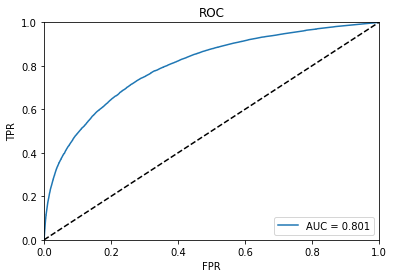

In [21]:
# best cluster replacement model at 100 trees 
CAT_FEATURES = ['nat_string', 'case_type_string', 'strCustody', 'strProbono', 'kmeans-15']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=100))

X_train, X_test, y_train, y_test = get_model_data(df_cluster, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_cluster_replacement_model, rf_cluster_replacement_metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

In [22]:
feature_importances_cr = pd.Series(data=rf_cluster_replacement_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances_cr.head(20)

datAppealFiled_year               0.195375
comp_year                         0.119433
osc_year                          0.103235
input_year                        0.098548
nat_string:::EL SALVADOR          0.027598
nat_string:::HAITI                0.023601
lawyer                            0.016117
kmeans-15:::12                    0.015228
kmeans-15:::3                     0.012692
strCustody:::N                    0.012030
nat_string:::GUATEMALA            0.012023
kmeans-15:::11                    0.011070
nat_string:::CHINA                0.010922
strCustody:::D                    0.010554
kmeans-15:::7                     0.010129
kmeans-15:::6                     0.009678
strCustody:::R                    0.009554
kmeans-15:::10                    0.009202
kmeans-15:::8                     0.009090
case_type_string:::DEPORTATION    0.008635
dtype: float64

In [23]:
collapsed_feature_importances_cr = collapse_feature_importances(feature_importances_cr)
collapsed_feature_importances_cr

parent_feature
nat_string             0.270644
datAppealFiled_year    0.195375
comp_year              0.119433
kmeans-15              0.113897
osc_year               0.103235
input_year             0.098548
strCustody             0.032138
case_type_string       0.019131
lawyer                 0.016117
oral                   0.008150
defensive              0.007777
affirmative            0.007236
written                0.007224
strProbono             0.001093
Name: importance, dtype: float64

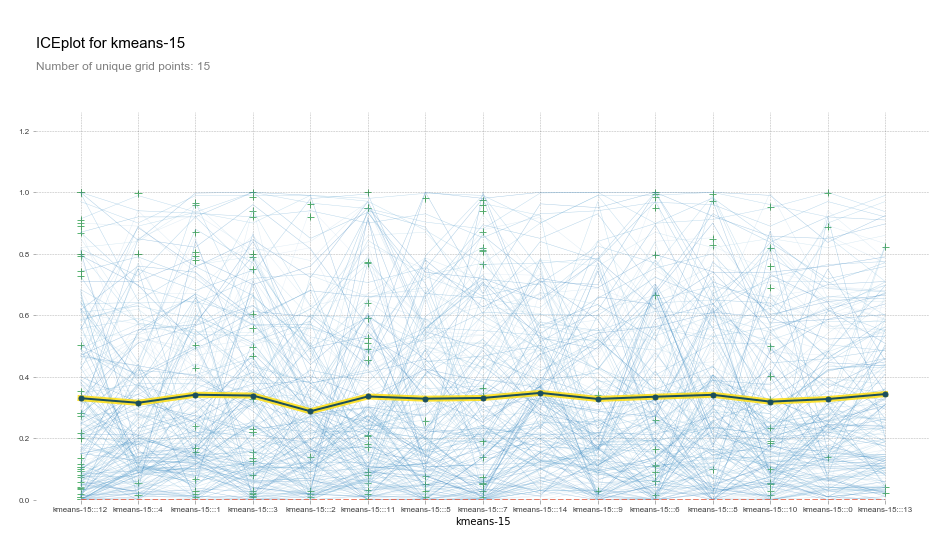

In [24]:
pdp_plot(rf_cluster_replacement_model, X_train, 'kmeans-15', feature_is_cat=True)

In [125]:
cluster_addition = {} 
for cm in cluster_models: 
    CAT_FEATURES = [cm, 'nat_string', 'case_type_string', 'strCustody', 'strProbono', 'ij_code']
    NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                    'comp_year', 'osc_year', 'input_year']
    IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                      'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
    MODEL = (RandomForestClassifier(n_estimators=10))

    X_train, X_test, y_train, y_test = get_model_data(df_cluster, label='granted', cat_features = CAT_FEATURES, 
                                                      num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
    _, cluster_addition[cm] = train_model(model=MODEL, plot_auc=False, print_metrics=False)

Training Data: (197824, 660) | Test Data: (49456, 660)
Training Data: (197824, 660) | Test Data: (49456, 660)
Training Data: (197824, 660) | Test Data: (49456, 660)
Training Data: (197824, 661) | Test Data: (49456, 661)
Training Data: (197824, 661) | Test Data: (49456, 661)
Training Data: (197824, 661) | Test Data: (49456, 661)
Training Data: (197824, 662) | Test Data: (49456, 662)
Training Data: (197824, 662) | Test Data: (49456, 662)
Training Data: (197824, 662) | Test Data: (49456, 662)
Training Data: (197824, 664) | Test Data: (49456, 664)
Training Data: (197824, 664) | Test Data: (49456, 664)
Training Data: (197824, 664) | Test Data: (49456, 664)
Training Data: (197824, 666) | Test Data: (49456, 666)
Training Data: (197824, 666) | Test Data: (49456, 666)
Training Data: (197824, 666) | Test Data: (49456, 666)
Training Data: (197824, 671) | Test Data: (49456, 671)
Training Data: (197824, 671) | Test Data: (49456, 671)
Training Data: (197824, 671) | Test Data: (49456, 671)
Training D

In [127]:
pd.DataFrame.from_dict(cluster_addition, orient='index').sort_values(by='ROC AUC', ascending=False)

Log Loss   ROC AUC  Accuracy
hierarchical-4   1.265674  0.803745  0.772464
kmeans-6         1.250309  0.803740  0.772141
kmeans-20        1.278056  0.803737  0.773415
GMM-5            1.277779  0.803453  0.771979
GMM-6            1.282908  0.803398  0.772242
GMM-4            1.286715  0.803101  0.772282
GMM-10           1.274175  0.802890  0.769533
hierarchical-8   1.301868  0.802833  0.772262
GMM-8            1.249859  0.802803  0.773051
kmeans-4         1.275347  0.802679  0.769896
kmeans-10        1.286690  0.802585  0.771575
kmeans-15        1.277754  0.802454  0.771635
kmeans-5         1.286535  0.802302  0.770220
hierarchical-5   1.258729  0.802198  0.770766
hierarchical-6   1.290332  0.801980  0.771352
hierarchical-10  1.292920  0.801756  0.771838
GMM-15           1.287506  0.800999  0.771696
kmeans-8         1.284552  0.800800  0.769573
hierarchical-20  1.312214  0.800694  0.769977
GMM-20           1.278841  0.800534  0.770503
hierarchical-15  1.331509  0.799234  0.771029

Training Data: (197824, 660) | Test Data: (49456, 660)
{'Accuracy': 0.7812601099967648, 'ROC AUC': 0.8221301077595203, 'Log Loss': 0.6313877701506565}


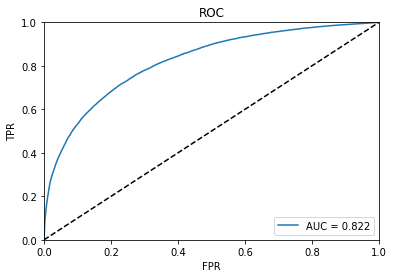

In [19]:
# best cluster addition model at 100 trees 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono', 'hierarchical-4']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=100))

X_train, X_test, y_train, y_test = get_model_data(df_cluster, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_cluster_addition_model, rf_cluster_addition_metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

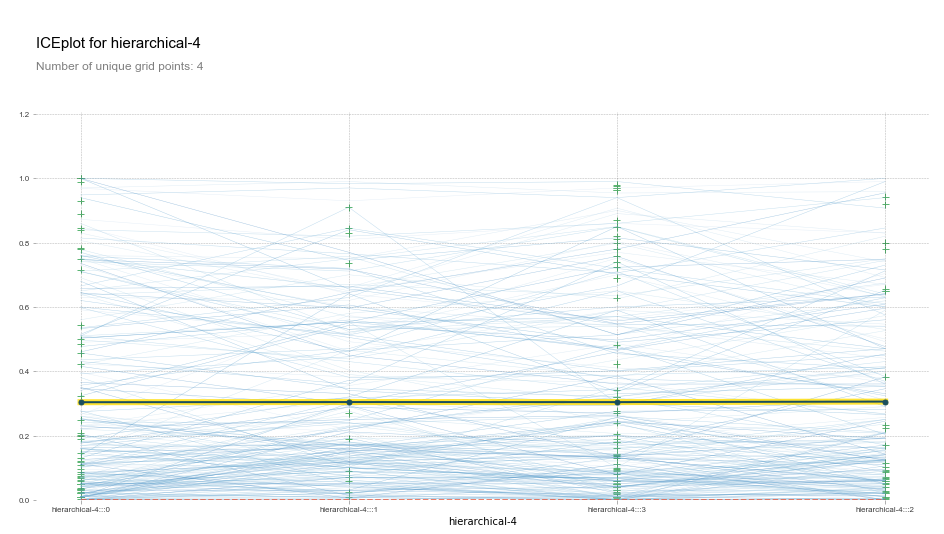

In [20]:
pdp_plot(rf_cluster_addition_model, X_train, 'hierarchical-4', feature_is_cat=True)

# Add Judge Variables

Adding judge features didn't appear to help either. Most of the information likely already captured by ij code. 

In [33]:
df2 = load_data(filename="data_for_model_with_judge_2018-05-07.csv", root_path=DATAFOLDER)
df2.set_index('idnAppeal', inplace=True) 
df2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247280 entries, 4657002 to 5021568
Data columns (total 27 columns):
nat_string               247121 non-null object
strCustody               206419 non-null object
strProbono               486 non-null object
case_type_string         247278 non-null object
ij_code                  247280 non-null object
lawyer                   247280 non-null int64
defensive                241611 non-null float64
affirmative              241611 non-null float64
oral                     246827 non-null float64
written                  246827 non-null float64
comp_year                247280 non-null int64
osc_year                 247280 non-null float64
input_year               247269 non-null float64
datAppealFiled_year      247280 non-null float64
granted                  247280 non-null int64
Male_judge               230908 non-null float64
Year_Appointed_SLR       230908 non-null float64
Year_College_SLR         230908 non-null float64
Year_Law_schoo

Training Data: (197824, 669) | Test Data: (49456, 669)
{'Accuracy': 0.7813612099644128, 'ROC AUC': 0.8218109155075759, 'Log Loss': 0.4824718784679469}


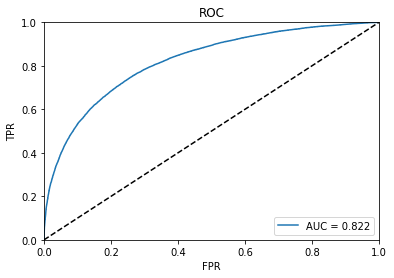

In [36]:
# retrain with best params on 100 trees 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono', 'Male_judge']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 'Year_Appointed_SLR', 'Year_College_SLR', 
                'Year_Law_school_SLR', 'Government_Years_SLR', 'Govt_nonINS_SLR', 'INS_Years_SLR', 
                'Military_Years_SLR', 'NGO_Years_SLR', 'Privateprac_Years_SLR', 'Academia_Years_SLR', 
                'judge_missing_bio']

IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero', 
                  'Male_judge': 'none', 'Year_Appointed_SLR': 'mode', 'Year_College_SLR': 'mode', 
                  'Year_Law_school_SLR': 'mode', 'Government_Years_SLR': 'zero', 'Govt_nonINS_SLR': 'zero', 
                  'INS_Years_SLR': 'zero', 'Military_Years_SLR': 'zero', 'NGO_Years_SLR': 'zero', 
                  'Privateprac_Years_SLR': 'zero', 'Academia_Years_SLR': 'zero'}

MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=10, max_features='sqrt', 
                                max_depth=100, min_samples_leaf=1))

X_train, X_test, y_train, y_test = get_model_data(df2, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_judge_model, rf_judge_metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

In [37]:
feature_importances = pd.Series(data=rf_judge_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.head(20)

datAppealFiled_year               0.139951
comp_year                         0.078548
osc_year                          0.069109
input_year                        0.066857
nat_string:::EL SALVADOR          0.030558
nat_string:::HAITI                0.026250
Year_College_SLR                  0.023445
Year_Law_school_SLR               0.022929
Year_Appointed_SLR                0.022745
Government_Years_SLR              0.016568
Privateprac_Years_SLR             0.016319
INS_Years_SLR                     0.016005
nat_string:::GUATEMALA            0.014810
lawyer                            0.013878
Govt_nonINS_SLR                   0.013406
strCustody:::N                    0.012938
strCustody:::D                    0.011645
case_type_string:::DEPORTATION    0.011357
nat_string:::CHINA                0.011306
nat_string:::NICARAGUA            0.010081
dtype: float64

In [41]:
collapsed_feature_importances = collapse_feature_importances(feature_importances)
collapsed_feature_importances

parent_feature
nat_string               0.263892
datAppealFiled_year      0.139951
ij_code                  0.122998
comp_year                0.078548
osc_year                 0.069109
input_year               0.066857
strCustody               0.032452
case_type_string         0.024506
Year_College_SLR         0.023445
Year_Law_school_SLR      0.022929
Year_Appointed_SLR       0.022745
Government_Years_SLR     0.016568
Privateprac_Years_SLR    0.016319
INS_Years_SLR            0.016005
lawyer                   0.013878
Govt_nonINS_SLR          0.013406
Male_judge               0.008933
affirmative              0.008488
defensive                0.007467
NGO_Years_SLR            0.007307
oral                     0.006813
written                  0.005936
Military_Years_SLR       0.005911
Academia_Years_SLR       0.002769
judge_missing_bio        0.001774
strProbono               0.000995
Name: importance, dtype: float64

Training Data: (197824, 657) | Test Data: (49456, 657)
{'Accuracy': 0.7838078291814946, 'ROC AUC': 0.8273676964682568, 'Log Loss': 0.4697287760517412}


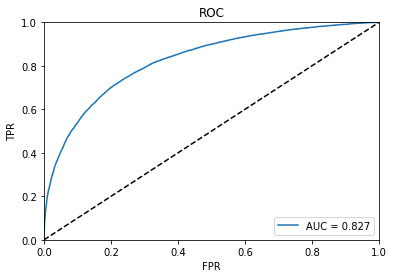

In [54]:
# retrain with best params on 100 trees 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 'Year_Appointed_SLR']

IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero', 
                  'Year_Appointed_SLR': 'mode'}

MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=10, max_features='sqrt', 
                                max_depth=100, min_samples_leaf=1))

X_train, X_test, y_train, y_test = get_model_data(df2, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_judge_model, rf_judge_metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

# Add Trend Variables

In [43]:
df3 = load_data(filename="data_for_model_with_trends_2018-05-07.csv", root_path=DATAFOLDER)
df3.set_index('idnAppeal', inplace=True) 
df3.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247280 entries, 4657002 to 5021568
Data columns (total 28 columns):
nat_string                247121 non-null object
strCustody                206419 non-null object
strProbono                486 non-null object
case_type_string          247278 non-null object
ij_code                   247280 non-null object
lawyer                    247280 non-null int64
defensive                 241611 non-null float64
affirmative               241611 non-null float64
oral                      246827 non-null float64
written                   246827 non-null float64
comp_year                 247280 non-null int64
osc_year                  247280 non-null float64
input_year                247269 non-null float64
datAppealFiled_year       247280 non-null float64
granted                   247280 non-null int64
Male_judge                230908 non-null float64
Year_Appointed_SLR        230908 non-null float64
Year_College_SLR          230908 non-null floa

Training Data: (197824, 657) | Test Data: (49456, 657)
{'Accuracy': 0.783888709155613, 'ROC AUC': 0.827399549500948, 'Log Loss': 0.46781791493748937}


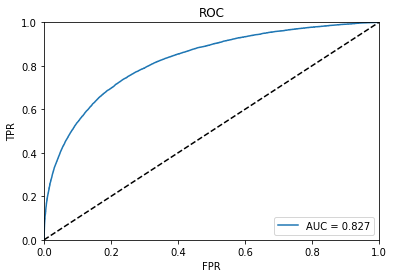

In [47]:
# retrain with best params on 100 trees 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 'year_since_appointment']

IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero', 
                  }

MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=10, max_features='sqrt', 
                                max_depth=100, min_samples_leaf=1))

X_train, X_test, y_train, y_test = get_model_data(df3, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_trend_model, rf_trend_metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

In [48]:
feature_importances = pd.Series(data=rf_trend_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.head(20)

datAppealFiled_year               0.126393
comp_year                         0.061015
osc_year                          0.056825
input_year                        0.056481
year_since_appointment            0.052867
nat_string:::EL SALVADOR          0.032781
nat_string:::HAITI                0.029247
nat_string:::GUATEMALA            0.014735
lawyer                            0.013077
case_type_string:::DEPORTATION    0.012943
strCustody:::D                    0.011639
strCustody:::N                    0.011444
nat_string:::NICARAGUA            0.009487
nat_string:::CHINA                0.009228
nat_string:::IRAQ                 0.007807
affirmative                       0.006930
strCustody:::R                    0.006368
defensive                         0.006364
oral                              0.006022
case_type_string:::REMOVAL        0.005806
dtype: float64

In [49]:
collapsed_feature_importances = collapse_feature_importances(feature_importances)
collapsed_feature_importances

parent_feature
ij_code                   0.306319
nat_string                0.247583
datAppealFiled_year       0.126393
comp_year                 0.061015
osc_year                  0.056825
input_year                0.056481
year_since_appointment    0.052867
strCustody                0.029450
case_type_string          0.024398
lawyer                    0.013077
affirmative               0.006930
defensive                 0.006364
oral                      0.006022
written                   0.005249
strProbono                0.001027
Name: importance, dtype: float64

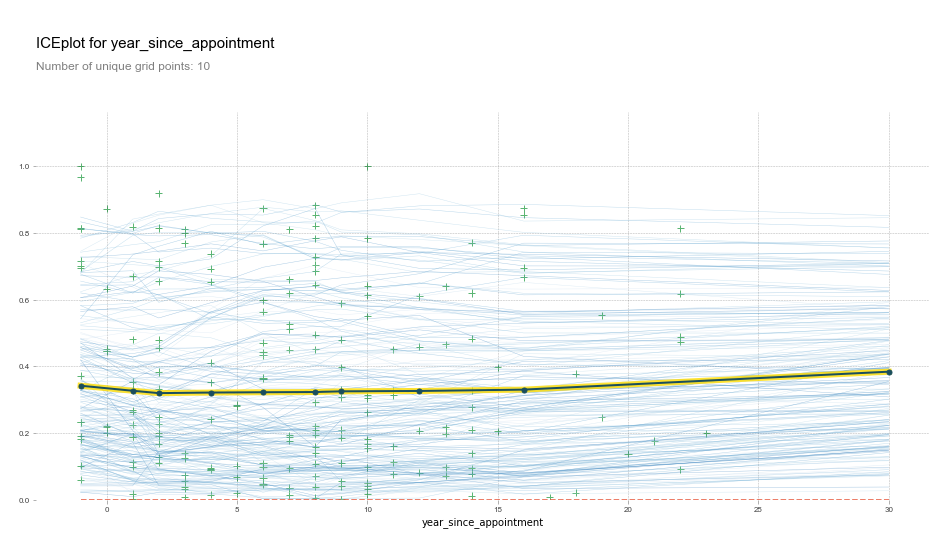

In [52]:
pdp_plot(rf_trend_model, X_train, 'year_since_appointment', feature_is_cat=False)

# Sequential Models

Thus far we aggregated data across time as a single population from which we drew train and test samples from. This might not be the most realistic way to build a model that is used to predict future appeal outcomes (i.e. we do not have the luxury of using data from future appeals to inform the outcome of a current appeal). To more realistically assess the power of our predictive models, we will build a series of models: one model to predict each year's of appeals (by datAppealFiled_year) between 2001 and 2013 using data in preceeding years. In other words, we will only use data from 2000 and earlier to predict 2001's appeals, data from 2001 and earlier to predict 2002's appeals etc. 

In [177]:
df.groupby('datAppealFiled_year')['granted'].agg(['size', np.mean])

size      mean
datAppealFiled_year                 
1973.0                   1  1.000000
1975.0                   1  0.000000
1977.0                   1  1.000000
1979.0                   2  0.000000
1980.0                   3  0.333333
1981.0                  24  0.916667
1982.0                  38  0.289474
1983.0                  55  0.218182
1984.0                 207  0.178744
1985.0                1042  0.181382
1986.0                1794  0.285953
1987.0                2071  0.374215
1988.0                2878  0.427728
1989.0                3924  0.409276
1990.0                4483  0.451260
1991.0                3256  0.217752
1992.0                3724  0.328947
1993.0                3980  0.380151
1994.0                5121  0.402656
1995.0                8394  0.323922
1996.0               10143  0.371488
1997.0                8046  0.431892
1998.0                7887  0.386078
1999.0                9710  0.346962
2000.0                9099  0.290471
2001.0                9019  0.227963
2002.0               13775  0.227804
2003.0               16364  0.209118
2004.0               15758  0.234611
2005.0               15993  0.291440
2006.0               15257  0.304057
2007.0               14587  0.291972
2008.0               13088  0.317008
2009.0               11661  0.387017
2010.0               10378  0.377915
2011.0               10982  0.342469
2012.0                9074  0.355962
2013.0                5163  0.507651
2014.0                 297  0.670034

In [101]:
def get_model_data_sequential(df, label, cat_features, num_features, impute_methods, predict_year): 
    """ Subsets variables used for model, runs it through pipeline to output data for model """
    
    # subsets features we are interested in 
    cat_feature_values = dict([(f, [str(x) for x in df[f].dropna().unique().tolist()]) for f in cat_features]) # do EDA and limit to smaller list
    data = df[cat_features + num_features + [label]].copy() 
    
    # train test split 
    train_data = data[data['datAppealFiled_year'] < predict_year]
    test_data = data[data['datAppealFiled_year'] == predict_year]
    x_train, y_train = train_data.drop(label, axis=1).copy(), train_data[label].copy() 
    x_test, y_test = test_data.drop(label, axis=1).copy(), test_data[label].copy() 
    
    # make pipeline 
    data_pipeline = Pipeline([
        ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
        ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
        ('dummify', Dummify(cat_feature_values))
    ])
    
    # run pipeline 
    X_train = data_pipeline.fit_transform(x_train)
    X_test = data_pipeline.transform(x_test)
    print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
    return X_train, X_test, y_train, y_test 

In [117]:
sequential_results = {}
for year in np.arange(2001, 2014, 1): 
    CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
    NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                    'comp_year', 'osc_year', 'input_year']
    IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                      'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
    MODEL = (RandomForestClassifier(n_estimators=10, min_samples_split=10, max_features='sqrt', 
                                    max_depth=90, min_samples_leaf=1))

    X_train, X_test, y_train, y_test = get_model_data_sequential(df, label='granted', cat_features = CAT_FEATURES, 
                                                                 num_features = NUM_FEATURES, 
                                                                 impute_methods = IMPUTE_METHODS, predict_year=year) 
    print("Training model to predict {} appeals...".format(year)) 
    _, sequential_results[year] = train_model(model=MODEL, plot_auc=False, print_metrics=True) 

Training Data: (85884, 656) | Test Data: (9019, 656)
Training model to predict 2001 appeals...
{'Log Loss': 0.54943840193677906, 'ROC AUC': 0.7266549887649616, 'Accuracy': 0.7773589089699523}
Training Data: (94903, 656) | Test Data: (13775, 656)
Training model to predict 2002 appeals...
{'Log Loss': 0.59011666313637656, 'ROC AUC': 0.69814584396504786, 'Accuracy': 0.77023593466424678}
Training Data: (108678, 656) | Test Data: (16364, 656)
Training model to predict 2003 appeals...
{'Log Loss': 0.58345248471400457, 'ROC AUC': 0.70837180918039122, 'Accuracy': 0.7842214617452945}
Training Data: (125042, 656) | Test Data: (15758, 656)
Training model to predict 2004 appeals...
{'Log Loss': 0.59419255341583466, 'ROC AUC': 0.69459887847630197, 'Accuracy': 0.77573296103566447}
Training Data: (140800, 656) | Test Data: (15993, 656)
Training model to predict 2005 appeals...
{'Log Loss': 0.65024142894131332, 'ROC AUC': 0.70621278336593418, 'Accuracy': 0.72425436128306131}
Training Data: (156793, 65

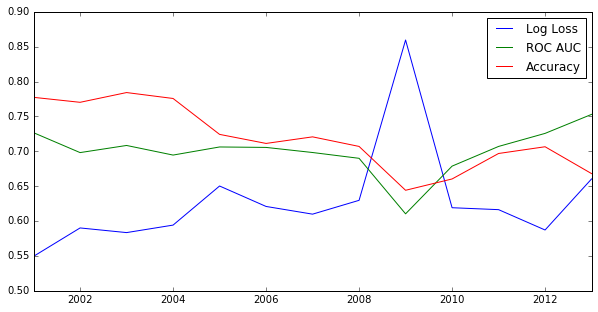

In [128]:
sequential_results_df = pd.DataFrame.from_dict(sequential_results, orient='index') 
sequential_results_df.plot(figsize=(10, 5))

It appears that building the model in a sequential way degraded the performance considerably. Perhaps even more surprisingly, accuracy appears to be worse in later years, which is somewhat counterintuitive given that later models had more data to train on. 

In [132]:
df[(df['datAppealFiled_year'] >= 2001) & (df['datAppealFiled_year'] <= 2013)].groupby('datAppealFiled_year')['granted'].mean()

datAppealFiled_year
2001.0    0.227963
2002.0    0.227804
2003.0    0.209118
2004.0    0.234611
2005.0    0.291440
2006.0    0.304057
2007.0    0.291972
2008.0    0.317008
2009.0    0.387017
2010.0    0.377915
2011.0    0.342469
2012.0    0.355962
2013.0    0.507651
Name: granted, dtype: float64

#### Weighting Samples  

One reason could be that there are periodic shifts in sentiment such that older data might be less informative to newer cases. Let's attempt to 

In [139]:
sequential_results_weighted = {}
alpha = 0.8
for year in np.arange(2001, 2014, 1): 
    CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
    NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                    'comp_year', 'osc_year', 'input_year']
    IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                      'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
    MODEL = (RandomForestClassifier(n_estimators=10, min_samples_split=10, max_features='sqrt', 
                                    max_depth=90, min_samples_leaf=1))

    X_train, X_test, y_train, y_test = get_model_data_sequential(df, label='granted', cat_features = CAT_FEATURES, 
                                                                 num_features = NUM_FEATURES, 
                                                                 impute_methods = IMPUTE_METHODS, predict_year=year) 
    sample_weight = X_train['datAppealFiled_year'].apply(lambda x: alpha ** (year-x-1))
    print("Training weighted model to predict {} appeals...".format(year)) 
    _, sequential_results_weighted[year] = train_model(model=MODEL, plot_auc=False, print_metrics=True, sample_weight=sample_weight)

Training Data: (85884, 656) | Test Data: (9019, 656)
Training weighted model to predict 2001 appeals...
{'Log Loss': 0.54221547093665712, 'ROC AUC': 0.73189520092584992, 'Accuracy': 0.78157223638984363}
Training Data: (94903, 656) | Test Data: (13775, 656)
Training weighted model to predict 2002 appeals...
{'Log Loss': 0.57537081662285172, 'ROC AUC': 0.69987510974745559, 'Accuracy': 0.76936479128856627}
Training Data: (108678, 656) | Test Data: (16364, 656)
Training weighted model to predict 2003 appeals...
{'Log Loss': 0.54347439514405471, 'ROC AUC': 0.70394251437492872, 'Accuracy': 0.78458812026399416}
Training Data: (125042, 656) | Test Data: (15758, 656)
Training weighted model to predict 2004 appeals...
{'Log Loss': 0.5843115643049015, 'ROC AUC': 0.68837043020672317, 'Accuracy': 0.77420992511740072}
Training Data: (140800, 656) | Test Data: (15993, 656)
Training weighted model to predict 2005 appeals...
{'Log Loss': 0.65754760956645519, 'ROC AUC': 0.70911694837251193, 'Accuracy': 

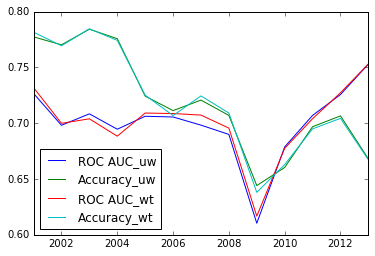

In [152]:
sequential_results_compare = sequential_results_df.merge(sequential_results_weighted_df, 
                                                         how='left', left_index=True, right_index=True,
                                                         suffixes=('_uw', '_wt'))
sequential_results_compare.drop(['Log Loss_uw', 'Log Loss_wt'], axis=1).plot()

In [153]:
sequential_results_weighted = {}
alpha = 0.7
for year in np.arange(2001, 2014, 1): 
    CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
    NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                    'comp_year', 'osc_year', 'input_year']
    IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                      'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
    MODEL = (RandomForestClassifier(n_estimators=10, min_samples_split=10, max_features='sqrt', 
                                    max_depth=90, min_samples_leaf=1))

    X_train, X_test, y_train, y_test = get_model_data_sequential(df, label='granted', cat_features = CAT_FEATURES, 
                                                                 num_features = NUM_FEATURES, 
                                                                 impute_methods = IMPUTE_METHODS, predict_year=year) 
    sample_weight = X_train['datAppealFiled_year'].apply(lambda x: alpha ** (year-x-1))
    print("Training weighted model to predict {} appeals...".format(year)) 
    _, sequential_results_weighted[year] = train_model(model=MODEL, plot_auc=False, print_metrics=True, sample_weight=sample_weight)

Training Data: (85884, 656) | Test Data: (9019, 656)
Training weighted model to predict 2001 appeals...
{'Log Loss': 0.52953025371160878, 'ROC AUC': 0.72991523846725137, 'Accuracy': 0.78057434305355355}
Training Data: (94903, 656) | Test Data: (13775, 656)
Training weighted model to predict 2002 appeals...
{'Log Loss': 0.55141122330956593, 'ROC AUC': 0.69059397872416795, 'Accuracy': 0.77212341197822143}
Training Data: (108678, 656) | Test Data: (16364, 656)
Training weighted model to predict 2003 appeals...
{'Log Loss': 0.50293402557346045, 'ROC AUC': 0.7136138949650922, 'Accuracy': 0.78354925446101198}
Training Data: (125042, 656) | Test Data: (15758, 656)
Training weighted model to predict 2004 appeals...
{'Log Loss': 0.64702692219713365, 'ROC AUC': 0.69863129488484921, 'Accuracy': 0.77243304987942629}
Training Data: (140800, 656) | Test Data: (15993, 656)
Training weighted model to predict 2005 appeals...
{'Log Loss': 0.69657280055150883, 'ROC AUC': 0.70540247942139622, 'Accuracy': 

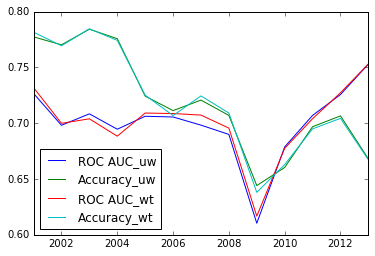

In [154]:
sequential_results_compare = sequential_results_df.merge(sequential_results_weighted_df, 
                                                         how='left', left_index=True, right_index=True,
                                                         suffixes=('_uw', '_wt'))
sequential_results_compare.drop(['Log Loss_uw', 'Log Loss_wt'], axis=1).plot()

In [158]:
sequential_results_weighted = {}
alpha = 0.3
for year in np.arange(2001, 2014, 1): 
    CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
    NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                    'comp_year', 'osc_year', 'input_year']
    IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                      'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
    MODEL = (RandomForestClassifier(n_estimators=10, min_samples_split=10, max_features='sqrt', 
                                    max_depth=90, min_samples_leaf=1))

    X_train, X_test, y_train, y_test = get_model_data_sequential(df, label='granted', cat_features = CAT_FEATURES, 
                                                                 num_features = NUM_FEATURES, 
                                                                 impute_methods = IMPUTE_METHODS, predict_year=year) 
    sample_weight = X_train['datAppealFiled_year'].apply(lambda x: alpha ** (year-x-1))
    print("Training weighted model to predict {} appeals...".format(year)) 
    _, sequential_results_weighted[year] = train_model(model=MODEL, plot_auc=False, print_metrics=True, sample_weight=sample_weight)

Training Data: (85884, 656) | Test Data: (9019, 656)
Training weighted model to predict 2001 appeals...
8.100000e-03    10143
3.000000e-01     9710
1.000000e+00     9099
2.430000e-03     8394
2.700000e-02     8046
9.000000e-02     7887
7.290000e-04     5121
5.904900e-06     4483
2.187000e-04     3980
1.771470e-06     3924
6.561000e-05     3724
1.968300e-05     3256
5.314410e-07     2878
1.594323e-07     2071
4.782969e-08     1794
1.434891e-08     1042
4.304672e-09      207
1.291402e-09       55
3.874205e-10       38
1.162261e-10       24
3.486784e-11        3
1.046035e-11        2
9.414318e-13        1
8.472886e-14        1
7.625597e-15        1
Name: datAppealFiled_year, dtype: int64
{'Log Loss': 0.53157515351874995, 'ROC AUC': 0.72916837804716528, 'Accuracy': 0.78367890009978936}
Training Data: (94903, 656) | Test Data: (13775, 656)
Training weighted model to predict 2002 appeals...
2.430000e-03    10143
9.000000e-02     9710
3.000000e-01     9099
1.000000e+00     9019
7.290000e-04  

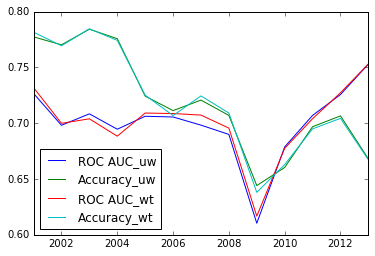

In [156]:
sequential_results_compare = sequential_results_df.merge(sequential_results_weighted_df, 
                                                         how='left', left_index=True, right_index=True,
                                                         suffixes=('_uw', '_wt'))
sequential_results_compare.drop(['Log Loss_uw', 'Log Loss_wt'], axis=1).plot()